In [241]:
import numpy as np
import cv2

from scipy.stats import mode
from scipy.optimize import curve_fit
from scipy.io import loadmat
from ImageProcessing import *

import numpy as np
import matplotlib.pyplot as plt

from ImageProcessing import *
from ImageGenerator import ImageGenerator
from ImageClassifier import *

from sklearn.mixture import GaussianMixture

# Loading Data

In [242]:
data = loadmat('jun1_run9.mat')
n_loops = 20
lattice_shape = np.array([10, 10])
stack = data['stack']

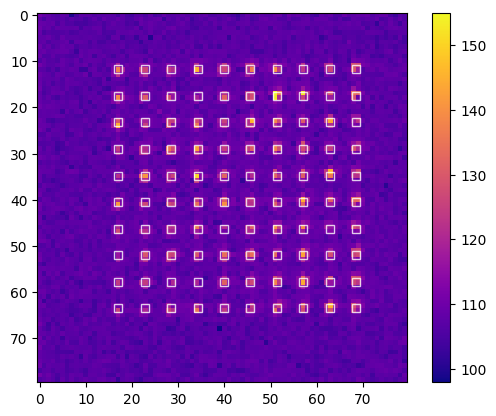

In [243]:
processor = GreenImageProcessor(stack, lattice_shape, 20)
processor.plot()

In [247]:
crops = processor.crop_sites(1)
crop = np.mean(crops, axis=(1,2)).flatten()
counts, bins = np.histogram(crop, bins=(processor.per_loop // 4))
centers = (bins[:-1] + bins[1:]) / 2

# Playing with Scikit's mixed gaussian model fitting

In [ ]:
tot = np.sum(crop)
mix = GaussianMixture(2)
mix.fit(np.reshape(crop, (crop.shape[0], 1)))
means = mix.means_.flatten()
weights = mix.weights_.flatten()
std = np.sqrt(mix.covariances_.flatten())
print(tot)

NameError: name 'crop' is not defined

In [ ]:
counts, bins, _ = plt.hist(crop, bins=(processor.per_loop  // 4), density=True)
x = np.linspace(centers[0], centers[-1])
print(counts)
#print(weights)
#print(gaussian(x, means[0], std[0], weights[0]))
plt.plot(x, 0.398942280401 * (gaussian(x, means[0], std[0], weights[0]) / std[0] + gaussian(x, means[1], std[1], weights[1] / std[1])))

NameError: name 'plt' is not defined

# Fixing anomolous bright/dark thresholding

In [ ]:
upper_thresh = 7
lower_thresh = 3
arr = np.array([8, 11, 11, 9, 8, 11, 9, 5, 2, 3, 2, 1, 3, 4, 5, 11, 10, 11, 10, 10])
over_thresh = np.arange(arr.size)[arr >= upper_thresh]
under_thresh = np.arange(arr.size)[arr <= lower_thresh]
labels = np.empty(arr.size)
print(over_thresh)
print(under_thresh)

[ 0  1  2  3  4  5  6 15 16 17 18 19]
[ 8  9 10 11 12]


In [ ]:
def slicer(arr, upper_thresh, lower_thresh, labels):
    head = tail = 0
    bright = True
    for i, val in enumerate(arr):
        if val >= upper_thresh and bright:
            head = i + 1
        elif val >= upper_thresh and not bright:
            labels[head:i] = np.full(i - head - 1, np.NaN)
            labels[tail:head] = np.zeros(head - tail)
            tail = i
            head = i + 1
            bright = True
        elif val <= lower_thresh and not bright:
            head = i + 1
        elif val <= lower_thresh and bright:
            labels[head:i] = np.full(i - head, np.NaN)
            labels[tail:head] = np.ones(head - tail)
            tail = i
            head = i + 1
            bright = False
    if bright:
        labels[tail:head] = np.ones(head - tail)
        labels[head:] = np.full(labels.size - head, np.NaN)
    else:
        labels[head:] = np.zeros(labels.size - head)


In [ ]:
slicer(arr, upper_thresh, lower_thresh, labels)
print(labels)

[ 1.  1.  1.  1.  1.  1.  1. nan  0.  0.  0.  0.  0. nan nan  1.  1.  1.
  1.  1.]


# Playing with openCV for site detection

In [312]:
img_width, img_height = stack.shape[1:]
n_loops = 20
per_loop = stack.shape[0] // n_loops


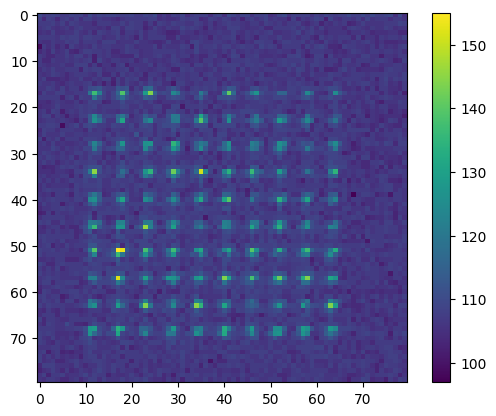

In [402]:
img = np.maximum(np.mean(stack, axis=0).astype('uint8'), np.zeros((img_width, img_height), dtype='uint8'))
og = np.copy(img)
plt.imshow(og)
plt.colorbar()

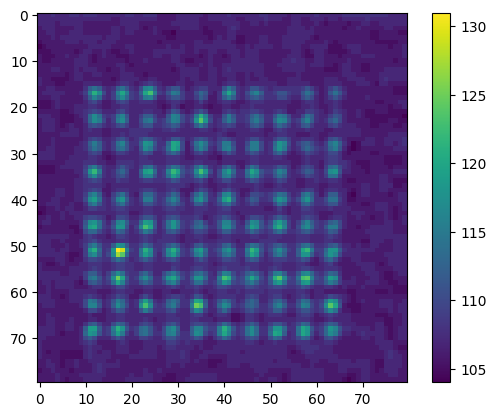

In [393]:
img = cv2.GaussianBlur(img, (3, 3), 0)
plt.imshow(img)
plt.colorbar()

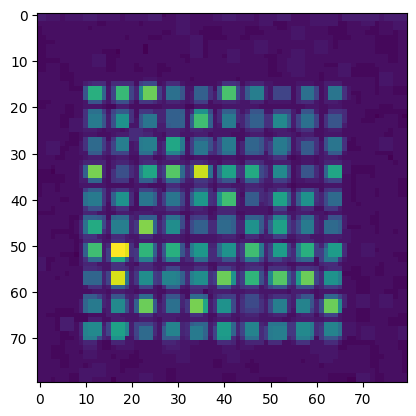

In [403]:
kernel = np.array(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype='uint8')
img = cv2.dilate(img, None)

plt.imshow(img)

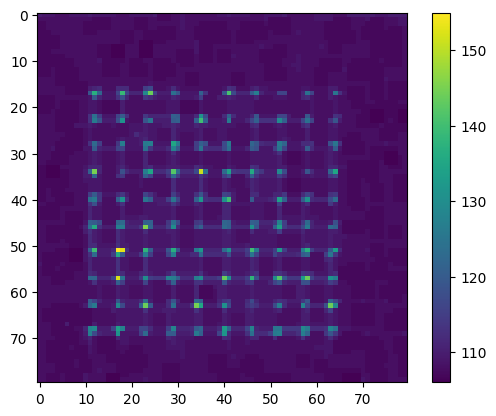

In [404]:
img = cv2.erode(img, None)
plt.imshow(img)
plt.colorbar()

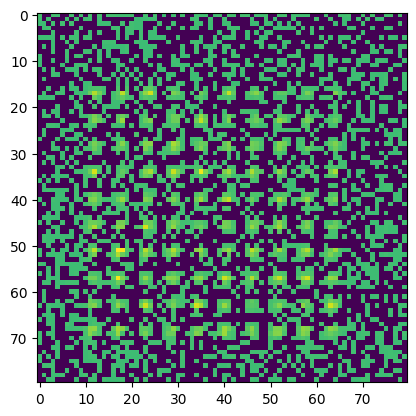

In [405]:
img = np.where(img == og, img, 0)
plt.imshow(img)

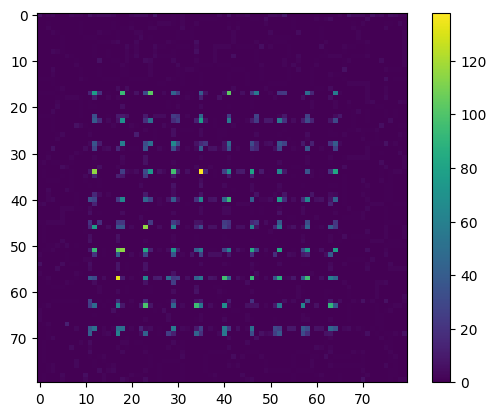

In [400]:
kernel = np.array(
    [
        [0, -1, 0],
        [-1, 4, -1],
        [0, -1, 0]
    ]
)

img = cv2.filter2D(img, -1, kernel)
#img = cv2.filter2D(img, -1, kernel)
plt.imshow(img)
plt.colorbar()

In [378]:
def find_positions_v1(img, n_tweezers, r=2):
    """ Find maxima in image by dilating then eroding. """
    positions = []
    # First find maxima and minima of whole image by dilatig followed by eroding
    dilate = cv2.dilate(img, None)
    erode = cv2.erode(dilate, None)
    # Now go through and find maxima and do replacements; increase of tweezer regions by one
    for i in range(n_tweezers):
        pos = np.unravel_index(np.argmax(erode), img.shape)
        # Check neighboring pixels to see if any have already been blacked out
        if any(erode[pos[0] - 1: pos[0] + 1, pos[1] - 1: pos[1] + 1] == 0):
            erode[pos] = 0
            i += 1
        else:
            r += 1
            region = img[pos[0] - r: pos[0] + r, pos[1] - r: pos[1] + r]
            dilate_region = cv2.dilate(region, None)
            erode_region = cv2.erode(dilate_region, None)
            erode[pos[0] - r: pos[0] + r, pos[1] - r: pos[1] + r] -= erode_region[1: -1, 1: -1]
            positions.append(pos)
            r -= 1
    return positions, erode

In [379]:
positions, erode = find_positions_v1(np.mean(stack, axis=0), 100)

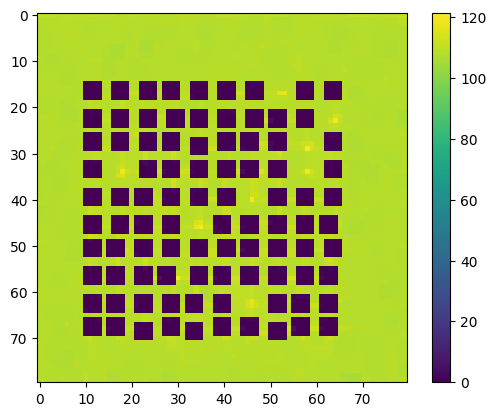

In [380]:
plt.imshow(erode)
plt.colorbar()

In [416]:
def find_positions_v2(img, n_tweezers, r=2):
    """ Find positions by applying a Gaussing blur to the input image to remove high frequency noise, 
    then find maxima in blurred image, removing from """
    positions = []
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    for i in range(n_tweezers):
        r += 1
        pos = np.unravel_index(np.argmax(blur), img.shape)
        region = img[pos[0] - r: pos[0] + r, pos[1] - r: pos[1] + r]
        blur_region = cv2.GaussianBlur(region, (3, 3), 0)
        r -= 1
        blur[pos[0] - r: pos[0] + r, pos[1] - r: pos[1] + r] -= blur_region[1: -1, 1: -1]
        positions.append(pos)
    return positions, blur

In [424]:
positions, blur = find_positions_v2(np.mean(stack, axis=0), 70)

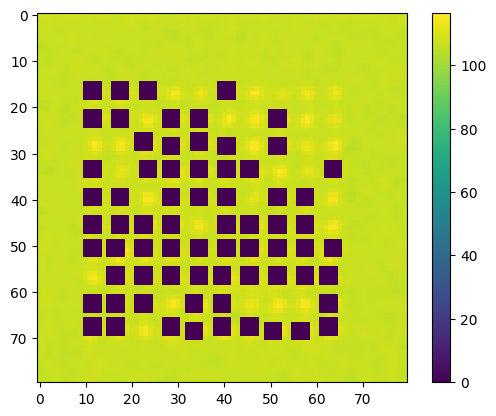

In [429]:
plt.imshow(blur)
plt.colorbar()